<a href="https://colab.research.google.com/github/Tasnim-47/Apolipoprotein/blob/main/Apolipoprotein_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install colorama

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np
import pandas as pd
import re
import plotly.offline as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
os.environ['QT_QPA_PLATFORM']='offscreen' # https://github.com/etetoolkit/ete/issues/296

import matplotlib.pyplot as plt
%matplotlib inline
from colorama import Back, Style, Fore

try:
    from Bio.Align.Applications import ClustalwCommandline
    from Bio import Align, pairwise2
except:
    !pip install biopython
    from Bio.Align.Applications import ClustalwCommandline
    from Bio import Align, pairwise2
try:
    from ete3 import Tree, TreeStyle
except:
    !pip install ete3
    import ete3
    from ete3 import Tree, TreeStyle
    from ete3 import PhyloTree,  TreeStyle
    #from ete3 import Tree, TreeStyle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning:

Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273785 sha256=a15a4b9b2cc0b7660125541425ab9faf6b9b02c1bef6ca9d51ab52a88a6fa483
  Stored in directory: /root/.cache/pip/wheels/a0/72/00/1982bd848e52b03079dbf800900120bc1c20e92e9a1216e525
Successfully built ete3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# AOPE_B genome reading
with open("/content/drive/MyDrive/gene.fasta", "r") as file:
    AOPE_B_genome = file.read().split("genome")[-1].replace("\n", "")

In [ ]:
AOPE_B_genome = AOPE_B_genome[89:]
#AOPE_B_genome[:3000]

In [ ]:
AOPE_B_genome

'CCAGGCCGCAGCCCAGGAGCCGCCCCACCGCAGCTGGCGATGGACCCGCCGAGGCCCGCGCTGCTGGCGCTGCTGGCGCTGCCTGCGCTGCTGCTGCTGCTGCTGGCGGGCGCCAGGGCCGGTGAGTGCGCGGCCGCTCTGCGGGCGCAGAGGGAGCGGGAGGGAGCCGGCGGCACGAGGTTGGCCGGGGCAGCCTGGGCCTAGGCCAGAGGGAGGGCAGCCACAGGGTCCAGGGCGAGTGGGGGGATTGGACCAGCTGGCGGCCCCTGCAGGCTCAGGATGGGGGGCGCGGGATGGAGGGGCTGAGGAGGGGGTCTCCGGAGCCTGCCTCCCTCCTGAAAGGTGAAACCTGTGCCGGTGGTCCCCCTGTCGGGCCCTAGCACCCGCTGGGAAGACGTGGGAAGCTCACAGATTTCTTTCTCCTGTCTTACAGAAGAGGAAATGCTGGAAAATGTCAGCCTGGTCTGTCCAAGTAAGGCATCTGCGCATGGGGCGTGGAAGGGCGCCCAGCCCCGTGCACTCTCCTACACCCGGGTCCCTGAGGGCCTCCCACTCTACAGGGCTGAGATGGCATCGTGGTGTGCCTTGCTCTGACCCCAGGAAGCAAGTTCCCTGAGCCTCTGCCCACACCCAAGGGATGCCAACTCTCTTCTACCTGGCCTTCTGTTCTGTCCCAAAAGTTCAGCCTGGGGGCGGGGGAGGGAAGGGATTGTCTCTCCGCTGGCCTGTGCACACTTTGAAGAAACATCACTGTCCTGTTTATCAGTGACTAGTCATTGATTCGAAGCATGTGAGGGTGAGGAAATACTGACTTTAACCTTTGTGAAGAAATCGAACCTCCACCCCCTTCCTATTTACCTGACCCCTGGGGGTTAAAGGAACTGGCCTCCAAGCGCGACCCTGTGTGCTGGAGCCGCGGGGCGGACTTCTGATGGGGCAGCACCGCCATCTAGTGGCCGTCTGTCATCACTGCAGCTGGACTCAGGACCCAGATGTTCT

In [ ]:
# some helper functions for representation of sequences

# usually DNA sequences are written in 10-nucleotide fashion
def ten_nucleotide_seq(genome):
    genes = []
    for ix, char in enumerate(genome):
        if ix != 0 and ix%10 == 0:
            genes.append(' ')
        genes.append(char)
    return ''.join(genes)

# color code to represent genome sequences
nu_clr_switcher = {
    # standard color-codes
    'A': Back.GREEN,
    'C': Back.YELLOW,
    'G': Back.RED,
    'T': Back.BLUE,
    ' ': Style.RESET_ALL
}
protein_clr_switcher = {
    # color-code by proteinfamily's polarity
    'A': Back.BLUE,
    'V': Back.BLUE,
    'I': Back.BLUE,
    'L': Back.BLUE,
    'M': Back.BLUE,
    'F': Back.BLUE,
    'Y': Back.CYAN,
    'W': Back.BLUE,
    'H': Back.CYAN,
    'R': Back.RED,
    'K': Back.RED,
    'N': Back.GREEN,
    'Q': Back.GREEN,
    'E': Back.MAGENTA,
    'D': Back.MAGENTA,
    'S': Back.GREEN,
    'T': Back.GREEN,
    'G': Back.YELLOW,
    'P': Back.YELLOW,
    'C': Back.BLUE,
    ' ': Style.RESET_ALL
}
def seq_repr(genome_str, strand ='dna'):
    if strand == 'dna':
        genome_str = ten_nucleotide_seq(genome=genome_str)
        line_break_cntr = 0
        for i in range(len(genome_str)):
            if genome_str[i] == ' ':
                line_break_cntr += 1
                if line_break_cntr>0 and line_break_cntr%6==0:
                    text = "\n"
                else:
                    text = nu_clr_switcher[genome_str[i]] + genome_str[i]
            else:
                text = nu_clr_switcher[genome_str[i]] + genome_str[i]
            print(text, end="")
        Style.RESET_ALL

    if strand == 'protein':
        for i in range(len(genome_str)):
            if genome_str[i] in protein_clr_switcher:
                if genome_str[i] == 'S' and genome_str[i+1:i+4] == 'TOP':
                    text = Style.RESET_ALL + 'S'
                elif genome_str[i] == 'T' and genome_str[i-1] == 'S' and genome_str[i+1:i+3] == 'OP':
                    text = Style.RESET_ALL + 'T'
                elif genome_str[i] == 'P' and genome_str[i-3:i] == 'STO':
                    text = Style.RESET_ALL + 'P'
                else:
                    text = protein_clr_switcher[genome_str[i]] + genome_str[i]
            else:
                Style.RESET_ALL
                text = genome_str[i]
            print(text, end="")

In [ ]:
print("AOPE B genome: ")
seq_repr(AOPE_B_genome)

AOPE B genome: 
CCAGGCCGCA GCCCAGGAGC CGCCCCACCG CAGCTGGCGA TGGACCCGCC GAGGCCCGCG
CTGCTGGCGC TGCTGGCGCT GCCTGCGCTG CTGCTGCTGC TGCTGGCGGG CGCCAGGGCC
GGTGAGTGCG CGGCCGCTCT GCGGGCGCAG AGGGAGCGGG AGGGAGCCGG CGGCACGAGG
TTGGCCGGGG CAGCCTGGGC CTAGGCCAGA GGGAGGGCAG CCACAGGGTC CAGGGCGAGT
GGGGGGATTG GACCAGCTGG CGGCCCCTGC AGGCTCAGGA TGGGGGGCGC GGGATGGAGG
GGCTGAGGAG GGGGTCTCCG GAGCCTGCCT CCCTCCTGAA AGGTGAAACC TGTGCCGGTG
GTCCCCCTGT CGGGCCCTAG CACCCGCTGG GAAGACGTGG GAAGCTCACA GATTTCTTTC
TCCTGTCTTA CAGAAGAGGA AATGCTGGAA AATGTCAGCC TGGTCTGTCC AAGTAAGGCA
TCTGCGCATG GGGCGTGGAA GGGCGCCCAG CCCCGTGCAC TCTCCTACAC CCGGGTCCCT
GAGGGCCTCC CACTCTACAG GGCTGAGATG GCATCGTGGT GTGCCTTGCT CTGACCCCAG
GAAGCAAGTT CCCTGAGCCT CTGCCCACAC CCAAGGGATG CCAACTCTCT TCTACCTGGC
CTTCTGTTCT GTCCCAAAAG TTCAGCCTGG GGGCGGGGGA GGGAAGGGAT TGTCTCTCCG
CTGGCCTGTG CACACTTTGA AGAAACATCA CTGTCCTGTT TATCAGTGAC TAGTCATTGA
TTCGAAGCAT GTGAGGGTGA GGAAATACTG ACTTTAACCT TTGTGAAGAA ATCGAACCTC
CACCCCCTTC CTATTTACCT GACCCCTGGG GGTTAAAGGA ACTGGCCTCC AAGCG

KeyError: ignored

In [ ]:
# Loading Complementary DNA Sequence into an alignable file
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
DNAsequence = SeqIO.read('/content/drive/MyDrive/gene(1).fasta.txt', "fasta")
DNAsequence

SeqRecord(seq=Seq('ATTCCCACCGGGACCTGCGGGGCTGAGTGCCCTTCTCGGTTGCTGCCGCTGAGG...ATA'), id='NC_000002.12:c21044073-21001429', name='NC_000002.12:c21044073-21001429', description='NC_000002.12:c21044073-21001429 APOB [organism=Homo sapiens] [GeneID=338] [chromosome=2]', dbxrefs=[])

Since input sequence is FASTA (DNA), and Apolipoprotein is in DNA form, we can convert to RNA by using transcribe() method will convert the DNA to mRNA.

In [ ]:
DNA = DNAsequence.seq          #Convert DNA into mRNA Sequence
mRNA = DNA.transcribe()        #Transcribe a DNA sequence into RNA.

In [ ]:
print(mRNA)

AUUCCCACCGGGACCUGCGGGGCUGAGUGCCCUUCUCGGUUGCUGCCGCUGAGGAGCCCGCCCAGCCAGCCAGGGCCGCGAGGCCGAGGCCAGGCCGCAGCCCAGGAGCCGCCCCACCGCAGCUGGCGAUGGACCCGCCGAGGCCCGCGCUGCUGGCGCUGCUGGCGCUGCCUGCGCUGCUGCUGCUGCUGCUGGCGGGCGCCAGGGCCGGUGAGUGCGCGGCCGCUCUGCGGGCGCAGAGGGAGCGGGAGGGAGCCGGCGGCACGAGGUUGGCCGGGGCAGCCUGGGCCUAGGCCAGAGGGAGGGCAGCCACAGGGUCCAGGGCGAGUGGGGGGAUUGGACCAGCUGGCGGCCCCUGCAGGCUCAGGAUGGGGGGCGCGGGAUGGAGGGGCUGAGGAGGGGGUCUCCGGAGCCUGCCUCCCUCCUGAAAGGUGAAACCUGUGCCGGUGGUCCCCCUGUCGGGCCCUAGCACCCGCUGGGAAGACGUGGGAAGCUCACAGAUUUCUUUCUCCUGUCUUACAGAAGAGGAAAUGCUGGAAAAUGUCAGCCUGGUCUGUCCAAGUAAGGCAUCUGCGCAUGGGGCGUGGAAGGGCGCCCAGCCCCGUGCACUCUCCUACACCCGGGUCCCUGAGGGCCUCCCACUCUACAGGGCUGAGAUGGCAUCGUGGUGUGCCUUGCUCUGACCCCAGGAAGCAAGUUCCCUGAGCCUCUGCCCACACCCAAGGGAUGCCAACUCUCUUCUACCUGGCCUUCUGUUCUGUCCCAAAAGUUCAGCCUGGGGGCGGGGGAGGGAAGGGAUUGUCUCUCCGCUGGCCUGUGCACACUUUGAAGAAACAUCACUGUCCUGUUUAUCAGUGACUAGUCAUUGAUUCGAAGCAUGUGAGGGUGAGGAAAUACUGACUUUAACCUUUGUGAAGAAAUCGAACCUCCACCCCCUUCCUAUUUACCUGACCCCUGGGGGUUAAAGGAACUGGCCUCCAAGCGCGACCCUGUGUGCUGG

In [ ]:
print('Size : ',len(mRNA))

Size :  42645


The difference between the DNA and the mRNA is just that the bases T (for Thymine) are replaced with U (for Uracil).
Next, we need to translate the mRNA sequence to amino-acid sequence using translate() method, we get something like IKGLYLPR*Q ( is so-called STOP codon, effectively is a separator for proteins, As STOP codon is not any protein)

In [ ]:
Amino_Acid = mRNA.translate(table=1, cds=False)
print('Amino Acid', Amino_Acid)

Amino Acid IPTGTCGAECPSRLLPLRSPPSQPGPRGRGQAAAQEPPHRSWRWTRRGPRCWRCWRCLRCCCCCWRAPGPVSARPLCGRRGSGREPAARGWPGQPGPRPEGGQPQGPGRVGGLDQLAAPAGSGWGARDGGAEEGVSGACLPPER*NLCRWSPCRALAPAGKTWEAHRFLSPVLQKRKCWKMSAWSVQVRHLRMGRGRAPSPVHSPTPGSLRASHSTGLRWHRGVPCSDPRKQVP*ASAHTQGMPTLFYLAFCSVPKVQPGGGGGKGLSLRWPVHTLKKHHCPVYQ*LVIDSKHVRVRKY*L*PL*RNRTSTPFLFT*PLGVKGTGLQARPCVLEPRGGLLMGQHRHLVAVCHHCSWTQDPDVLFLQLFRKFLSTTVETSRNSFLGVC*VSYA*CLMNFALSIW*S*SHGITACSS*KSIRDSTICVMLSSLNLPEGLSCRFSEPHYLTLVTPFPVPQMRYSRHASQFKH*PQQKHNGEVKSIKEN*V*SQLKNNLS*ITIFNSLCHCPSLPRIGCPWESYFCYVADVFLPTLEDATRFKHLRKYTYNYEAESSSGVPGTADSRSATRINCKVWRMQAGGT*SPQLSPSPVPAGAQHATFPEGVY*ANAEHPRTVVI*SKHWDFASVCKSATLLRCGLPPPNFASQKYFPVNFPDAIGIHDLD*QQCGSVDFSVREAQ*VSYGRQATRNRTVKCSFYNLSQTESVAEK*MERRKKYKHTVCSKIKLCLLLRLVVLMLHTCGADLQAAIGVWVGKRSQAEQSPFFREYRSSCMCCPIW*T*ATLGYLNGMKLKIHIRCHISCISTAQQPPWLLAPILNSTHVQHFYKVI*IVLDNK*ESVETPAICKALNRP**I*PVFWVTLRRHLLWKRRMALFLLSVFLLHFHS*SAALLFNHSSL*LK*VTLEPIKGHPPSHA*GQT*EMCYPGGGKRQQ*D*V*VGAQRTQEAC**GMWC*GAGSGVPSTIPFGALIRD*ALGFRGHLSFLIDNLN

In [ ]:
print("Length of Protein:",len(Amino_Acid))
print("Length of Original mRNA:",len(mRNA))

Length of Protein: 14215
Length of Original mRNA: 42645


In [ ]:
from Bio.Data import CodonTable
print(CodonTable.unambiguous_rna_by_name['Standard'])

Table 1 Standard, SGC0

  |  U      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
U | UUU F   | UCU S   | UAU Y   | UGU C   | U
U | UUC F   | UCC S   | UAC Y   | UGC C   | C
U | UUA L   | UCA S   | UAA Stop| UGA Stop| A
U | UUG L(s)| UCG S   | UAG Stop| UGG W   | G
--+---------+---------+---------+---------+--
C | CUU L   | CCU P   | CAU H   | CGU R   | U
C | CUC L   | CCC P   | CAC H   | CGC R   | C
C | CUA L   | CCA P   | CAA Q   | CGA R   | A
C | CUG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | AUU I   | ACU T   | AAU N   | AGU S   | U
A | AUC I   | ACC T   | AAC N   | AGC S   | C
A | AUA I   | ACA T   | AAA K   | AGA R   | A
A | AUG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GUU V   | GCU A   | GAU D   | GGU G   | U
G | GUC V   | GCC A   | GAC D   | GGC G   | C
G | GUA V   | GCA A   | GAA E   | GGA G   | A
G | GUG V   | GCG A   | GAG E   | GGG G   | G
--+---------

Let’s identify all the Proteins (chains of amino acids), basically separating at the stop codon, marked by *.

In [ ]:
#Identify all the Proteins (chains of amino acids)
Proteins = Amino_Acid.split('*') # * is translated stop codon
df = pd.DataFrame(Proteins)
df.describe()
print('Total proteins:', len(df))

def conv(item):
    if item is not None:
     print(len(item))
    else:
     print('None value Found in List')

def to_str(item):
    if item is not None:
     print(len(item))
    else:
     print('None value Found in List')

df['sequence_str'] = df[0].apply(to_str)

df['length'] = df[0].apply(conv)
df.rename(columns={0: "sequence"}, inplace=True)
df.head()# Take only longer than 20
functional_proteins = df.loc[df['length'] >= 20]
print('Total functional proteins:', len(functional_proteins))

functional_proteins.describe()


Total proteins: 773
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
None value Found in List
1
None value Found in List
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
None value Found in List
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

,sequence,1,2,3,4,5,6,7,8,9,...,145,146,147,148,149,150,151,152,sequence_str,length
count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from Bio import pairwise2

In [ ]:
#Squiggle wont work in Kaggle kernels, you need to run this command on terminal.

Squiggle DNAsequence --method=gates --separate

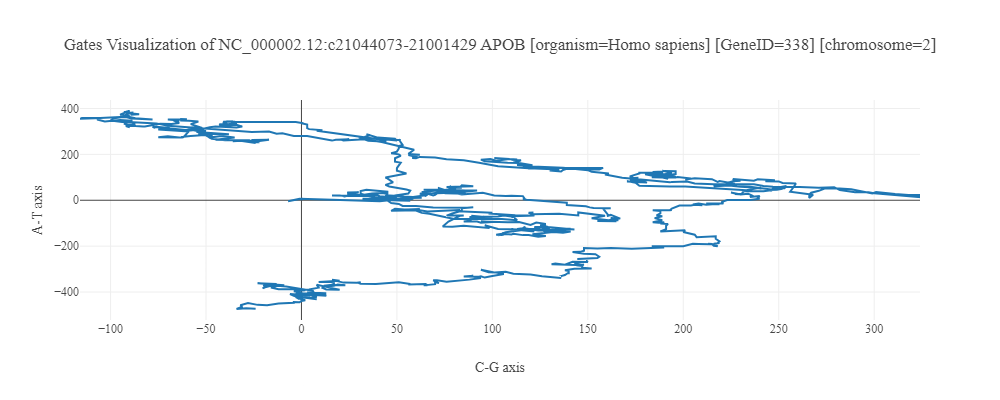

### Qi formate of the APOB DNA Sequence data. It shows the frequency of the Di-mers present in the sequence.

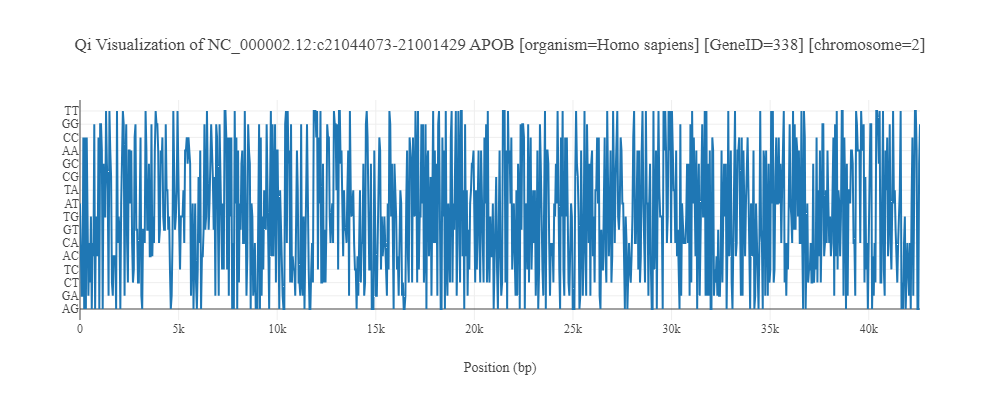

Looking into the composition of each neucleotide

In [ ]:
def nucleotides_composition(seq):
    nucleotides = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    for n in nucleotides:
        nucleotides[n] = seq.count(n)/len(seq)*100
    return nucleotides

In [ ]:
ndict=nucleotides_composition(DNAsequence)
ndict

{'A': 29.074920858248326,
 'C': 21.50076210575683,
 'G': 21.465587993903153,
 'T': 27.958729042091683}

Barplot to visualize the neucleotides

In [ ]:
import pandas as pd
import seaborn as sns

import pandas as pd
ndf = pd.DataFrame.from_dict(ndict, orient ='index')
ndf = ndf.reset_index()
ndf = ndf.rename(columns={"index": "Nucleotide", 0: "Composition"})

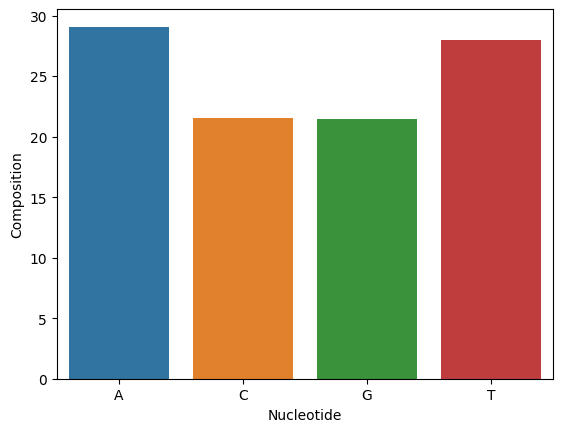

In [ ]:
ax = sns.barplot(x="Nucleotide", y="Composition", data=ndf)

In [ ]:
from Bio.SeqUtils import gc_fraction
print(f"GC% :{GC(DNAsequence)}")

In [ ]:
# Tri-nucleotide compositions (Tri-mer)
# tri-nucleotide compositions
trimers = ["AAA", "AAC", "AAG", "AAT", "ACA", "ACC", "ACG", "ACT", "AGA", "AGC", "AGG", "ATA", "ATC", "ATG", "CAA",
           "CAC", "CAG", "CCA","CCC","CCG","CGA","CGC","CTA","CTC","GAA","GAC","GCA","GCC","GGA","GTA","TAA","TCA"]

def trimer_composition(genome):
    trimer_dict = dict()
    for trimer in trimers:
        trimer_dict[trimer] = genome.count(trimer)
    return trimer_dict

In [ ]:
composition = trimer_composition(DNAsequence)
total_composition = sum(composition.values())
norm_freq = [count/total_composition for count in composition.values()]
print(composition)
print(total_composition)
print(norm_freq)

{'AAA': 930, 'AAC': 655, 'AAG': 997, 'AAT': 897, 'ACA': 771, 'ACC': 563, 'ACG': 117, 'ACT': 720, 'AGA': 949, 'AGC': 680, 'AGG': 813, 'ATA': 609, 'ATC': 585, 'ATG': 809, 'CAA': 871, 'CAC': 595, 'CAG': 960, 'CCA': 888, 'CCC': 430, 'CCG': 142, 'CGA': 118, 'CGC': 108, 'CTA': 520, 'CTC': 674, 'GAA': 961, 'GAC': 468, 'GCA': 673, 'GCC': 519, 'GGA': 755, 'GTA': 442, 'TAA': 717, 'TCA': 870}
20806
[0.04469864462174373, 0.03148130347015284, 0.0479188695568586, 0.04311256368355282, 0.03705661828318754, 0.027059502066711524, 0.005623377871767759, 0.034605402287801595, 0.045611842737671826, 0.032682879938479285, 0.03907526674997597, 0.029270402768432183, 0.028116889358838798, 0.03888301451504374, 0.04186292415649332, 0.028597519946169374, 0.04614053638373546, 0.0426799961549553, 0.020667115255214842, 0.006824954340094204, 0.005671440930500817, 0.005190810343170239, 0.02499279054119004, 0.03239450158608094, 0.04618859944246852, 0.022493511487071037, 0.03234643852734788, 0.024944727482456984, 0.036287

In [ ]:
tri = pd.DataFrame.from_dict(composition, orient ='index')
tri = tri.reset_index()
tri = tri.rename(columns={"index": "trimer", 0: "count"})
r1 = tri.sort_values(by='count', ascending=False)
r1.style.bar(subset=["count"],color='#').background_gradient(cmap='Reds')

,trimer,count
2,AAG,997
24,GAA,961
16,CAG,960
8,AGA,949
0,AAA,930
3,AAT,897
17,CCA,888
14,CAA,871
31,TCA,870
10,AGG,813


Proteins & Amino Acids

Attempts to find out the largest amino acid sequence in the fasta file.

In [ ]:
# lets have a look at the protein sequences of a few of these genome before we go for a comparative analysis
def gen_protein_seq(genome_str):
    # codon table from wiki
    protein = {"TTT" : "F", "CTT" : "L", "ATT" : "I", "GTT" : "V",
           "TTC" : "F", "CTC" : "L", "ATC" : "I", "GTC" : "V",
           "TTA" : "L", "CTA" : "L", "ATA" : "I", "GTA" : "V",
           "TTG" : "L", "CTG" : "L", "ATG" : "M", "GTG" : "V",
           "TCT" : "S", "CCT" : "P", "ACT" : "T", "GCT" : "A",
           "TCC" : "S", "CCC" : "P", "ACC" : "T", "GCC" : "A",
           "TCA" : "S", "CCA" : "P", "ACA" : "T", "GCA" : "A",
           "TCG" : "S", "CCG" : "P", "ACG" : "T", "GCG" : "A",
           "TAT" : "Y", "CAT" : "H", "AAT" : "N", "GAT" : "D",
           "TAC" : "Y", "CAC" : "H", "AAC" : "N", "GAC" : "D",
           "TAA" : "STOP", "CAA" : "Q", "AAA" : "K", "GAA" : "E",
           "TAG" : "STOP", "CAG" : "Q", "AAG" : "K", "GAG" : "E",
           "TGT" : "C", "CGT" : "R", "AGT" : "S", "GGT" : "G",
           "TGC" : "C", "CGC" : "R", "AGC" : "S", "GGC" : "G",
           "TGA" : "STOP", "CGA" : "R", "AGA" : "R", "GGA" : "G",
           "TGG" : "W", "CGG" : "R", "AGG" : "R", "GGG" : "G"
           }
    protein_seq = ""

    # generating the protein seq
    for i in range(0, len(AOPE_B_genome)-(3+len(AOPE_B_genome)%3), 3):
        protein_seq += protein[AOPE_B_genome[i:i+3]]
    return protein_seq

In [ ]:
# mRNA sequence
# Protein Synthesis
DNA_mrna = DNA.transcribe()
DNA_mrna

Seq('AUUCCCACCGGGACCUGCGGGGCUGAGUGCCCUUCUCGGUUGCUGCCGCUGAGG...AUA')

In [ ]:
DNA_protein = DNA_mrna.translate()
DNA_protein


Seq('IPTGTCGAECPSRLLPLRSPPSQPGPRGRGQAAAQEPPHRSWRWTRRGPRCWRC...CII')

In [ ]:
DNA_aa = DNA_protein.split("*")
DNA_aa[0:10]

[Seq('IPTGTCGAECPSRLLPLRSPPSQPGPRGRGQAAAQEPPHRSWRWTRRGPRCWRC...PER'),
 Seq('NLCRWSPCRALAPAGKTWEAHRFLSPVLQKRKCWKMSAWSVQVRHLRMGRGRAP...QVP'),
 Seq('ASAHTQGMPTLFYLAFCSVPKVQPGGGGGKGLSLRWPVHTLKKHHCPVYQ'),
 Seq('LVIDSKHVRVRKY'),
 Seq('L'),
 Seq('PL'),
 Seq('RNRTSTPFLFT'),
 Seq('PLGVKGTGLQARPCVLEPRGGLLMGQHRHLVAVCHHCSWTQDPDVLFLQLFRKF...GVC'),
 Seq('VSYA'),
 Seq('CLMNFALSIW')]

In [ ]:
#cleaning the DNA protein sequence of the sequence
DNA_clean = [ str(i) for i in DNA_aa]

In [ ]:
# Remove chains smaller than 20 amino acids long
for i in Proteins[:]:
    if len(i) < 20:
        Proteins.remove(i)

Protein Analysis

In [ ]:
df = pd.DataFrame({"amino_acids":DNA_clean})

In [ ]:
df['count'] = df['amino_acids'].str.len()

In [ ]:
df.nlargest(10, "count")

,amino_acids,count
480,DLWLQAELVPFTTISYVFSDEEKIEFEWNTGTNVDTKKMTSNFPVD...,153
0,IPTGTCGAECPSRLLPLRSPPSQPGPRGRGQAAAQEPPHRSWRWTR...,144
99,FLYDTIMGEDTDATCGGLSADPPLTGFLSPNLGWPGTSKTTLCIGR...,141
165,GLSWQRTHHEQYFMCPEGGLYNFIHVFLLSPITLQALVQCGQPQCS...,106
162,LLIPRSIAGALQKLIGWWRENSDEKYNMISLPFKALALSAMKVREG...,103
156,SSFDTFHLPGTKKMGLAFESTKSTSPPKQAEAVLKTLQELKKLTIS...,99
273,INGHQEWGLLGWHTTKKPDAIFLSDFLSQIGLEGKGFEPTLEALFG...,96
249,ASEELCGFPYCQYLELRRIGYPRVSKSYSPHIPLRALSWNSNPRFW...,95
1,NLCRWSPCRALAPAGKTWEAHRFLSPVLQKRKCWKMSAWSVQVRHL...,89
104,LLTSEKVPGMDVGQQNHLLFFSAQGLLVPAPSLWPLKKSQDLCSPP...,87


**Considers the Amino Acid of the highest length for the Analysis**

In [ ]:
# protein of interest
from Bio.Seq import Seq
soi=df['amino_acids'].iloc[480]
seq_oi=Seq(soi)
seq_oi

Seq('DLWLQAELVPFTTISYVFSDEEKIEFEWNTGTNVDTKKMTSNFPVDLSDYPKSL...ATK')

In [ ]:
#cleaning
soi1=''
for i in soi:
    if(i!='X'):
        soi1=soi1+i
print(len(soi1))

153


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
a = ProteinAnalysis(soi1)
a

In [ ]:
MW = a.molecular_weight()
MW

17791.251

**Aromaticity**

In chemistry, aromaticity is a property of cyclic (ring-shaped), planar (flat) structures with pi bonds in resonance (those containing delocalized electrons) that gives increased stability compared to other geometric or connective arrangements with the same set of atoms.
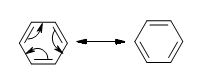


In [ ]:
aromaticity = a.aromaticity()
aromaticity

0.11764705882352941

**IsoElectric Point**

The isoelectric point (pI) is the pH value at which the molecule carries no electrical charge. The concept is particularly important for zwitterionic molecules such as amino acids, peptides, and proteins.

In [ ]:
IsoElectric = a.isoelectric_point()
IsoElectric

8.415138816833498

**Amino Acid Composition**

In [ ]:
def amino_acid_composition(protein_seq):
    amino_acids_dict = {'Y': 0, 'A': 0, 'Q': 0, 'D': 0, 'C': 0, 'G': 0, 'V': 0, 'T': 0, 'E': 0, 'N': 0,
                       'K': 0, 'R': 0, 'S': 0, 'I': 0, 'H': 0, 'M': 0, 'F': 0, 'L': 0, 'W': 0, 'P': 0}
    for amino_acid in amino_acids_dict:
        amino_acids_dict[amino_acid] = protein_seq.count(amino_acid)/len(protein_seq)*100
    return amino_acids_dict

In [ ]:
ac = amino_acid_composition(DNA_protein)
amc = pd.DataFrame.from_dict(ac, orient ='index')
amc = amc.reset_index()
amc = amc.rename(columns={"index": "amino_acid", 0: "composition"})

In [ ]:
r = amc.sort_values(by='composition', ascending=False)
r.style.bar(subset=["composition"],color='#').background_gradient(cmap='Purples')

,amino_acid,composition
17,L,11.607457
12,S,9.609567
19,P,5.824833
11,R,5.599719
10,K,5.578614
7,T,5.529370
5,G,5.219838
16,F,5.043968
13,I,4.839958
6,V,4.628913


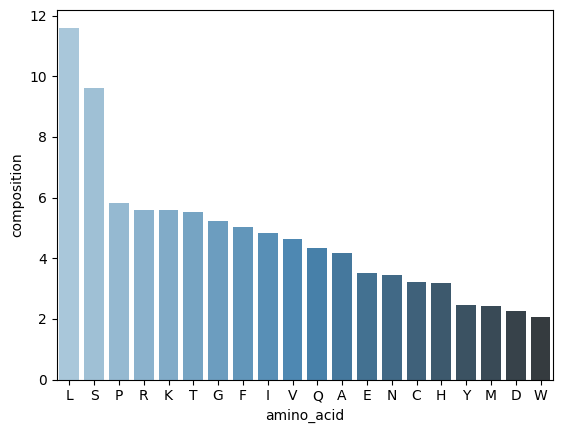

In [ ]:
ax = sns.barplot(x="amino_acid", y="composition", data=r,
                 palette="Blues_d")

**Finding the ORF**

In molecular genetics, an open reading frame is the part of a reading frame that has the ability to be translated. An ORF is a continuous stretch of codons that begins with a start codon and ends at a stop codon. An ATG codon within the ORF may indicate where translation starts.

In [ ]:
#ORF
orf_strands = []
# generate ORFs
for seq in DNA_protein.split("STOP"):
    for nu in range(len(seq)-1, -1, -1):
        if seq[nu] == "M":
            orf_strands.append(seq[nu:]+"STOP")

In [ ]:
orf_strands[0:10]

[Seq('MESLLCIISTOP'),
 Seq('MAFFAS*RKSGSELFC*TWGRRNK*MESLLCIISTOP'),
 Seq('MNWTCTKAGTRARKVSELRRMAFFAS*RKSGSELFC*TWGRRNK*MESLLCIISTOP'),
 Seq('MKNLLLNPKD*LTCPFKTTTHF*YTSRSY*KSCNQPQS*TPT*SLLQENLLSSS...TOP'),
 Seq('MEKGKRRLQSFLPLLRK*LKARPLRRRK*FLITTSSLDINCKIFQTNSLITMKN...TOP'),
 Seq('MNLKKR*SV*SRTC*LLLRTSILNILSVPLTLLPNSQVKLSNFCTEIFRNILAS...TOP'),
 Seq('MNLFKTSFRKLLKSYSRSINTLWPFVKNILIQV*LAGQ*NIMNLKKR*SV*SRT...TOP'),
 Seq('MFLNC*KKTYALIFISSMNLFKTSFRKLLKSYSRSINTLWPFVKNILIQV*LAG...TOP'),
 Seq('MRSTQSSVIISHMFLNC*KKTYALIFISSMNLFKTSFRKLLKSYSRSINTLWPF...TOP'),
 Seq('M*SRCIGNC*KIYQKKPKRYLKPFSLSRPQRCYVIFRTFYNSFSN**KITLNS*...TOP')]

In [ ]:
len(orf_strands)

346

In [ ]:
!pip install phylopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from Bio import SeqIO
with open('/content/drive/MyDrive/gene.fasta') as fasta_file:  # Will close handle cleanly
    identifiers = []
    lengths = []
#read Sequence from FASTA file
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(str(seq_record.seq))
        lengths.append(len(seq_record.seq))

In [ ]:
#store sequence in DataFrame
d = {'Sequence':identifiers,'Len':lengths}
data= pd.DataFrame(d)
data['label']="APOE_B"
data

,Sequence,Len,label
0,ATTCCCACCGGGACCTGCGGGGCTGAGTGCCCTTCTCGGTTGCTGC...,42645,APOE_B
1,ATTCCCACCGGGACCTGCGGGGCTGAGTGCCCTTCTCGGTTGCTGC...,42645,APOE_B
2,ATTCCCACCGGGACCTGCGGGGCTGAGTGCCCTTCTCGGTTGCTGC...,42646,APOE_B


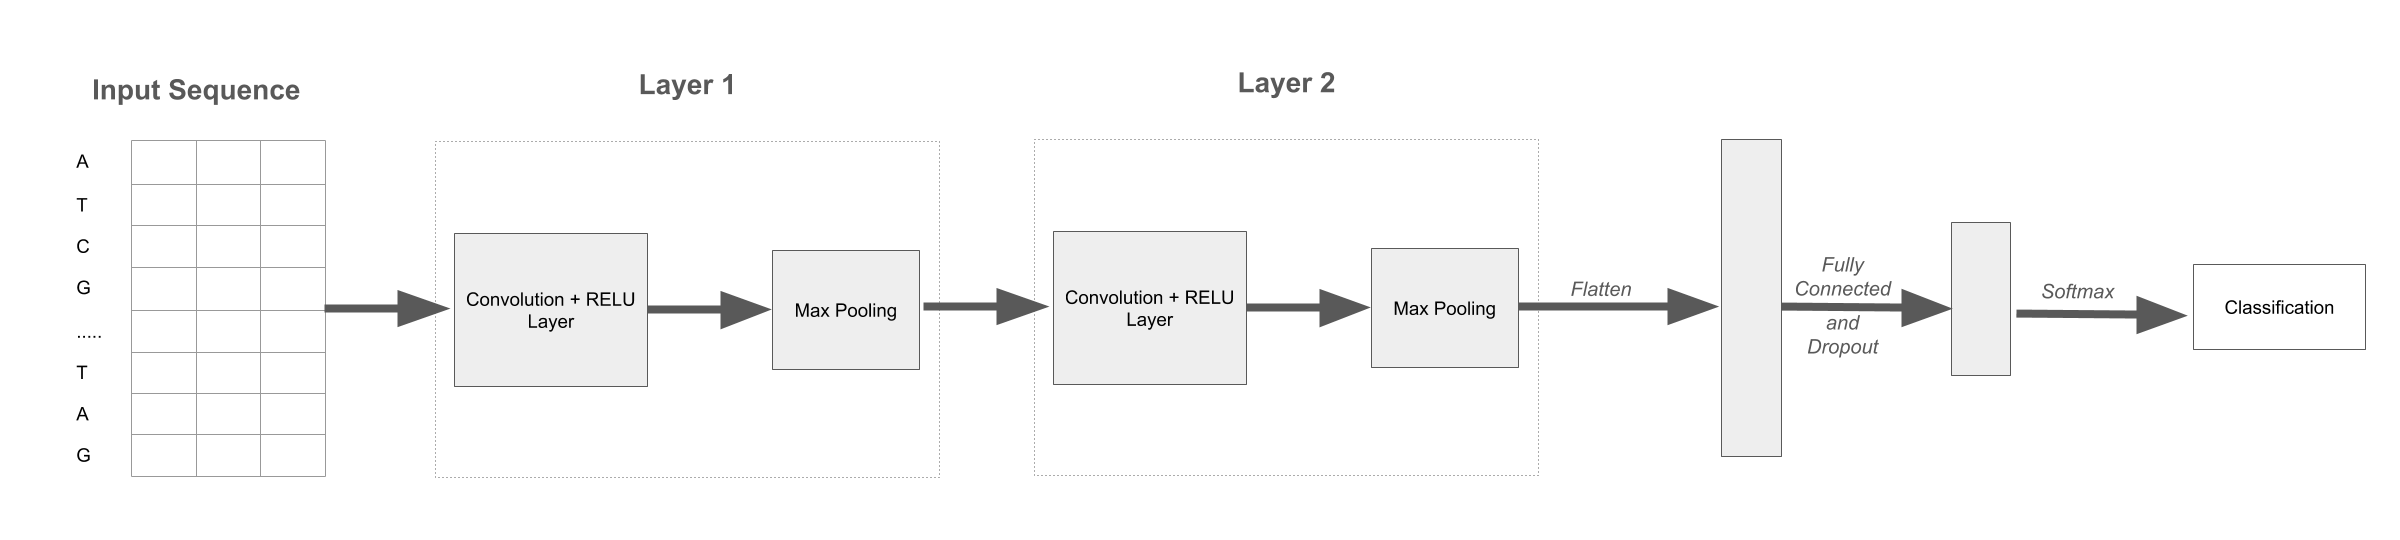